# 002 - Log Target Boosting (XGBoost)

## Objectif
Améliorer la performance de la baseline en s'attaquant à la distribution de la variable cible `SalePrice`.

## Hypothèse
Le prix de vente des maisons (`SalePrice`) suit souvent une distribution asymétrique (skewed) vers la droite (longue traîne des prix élevés). Les modèles de régression (linéaires ou arbres) peuvent être sensibles à cette asymétrie et aux valeurs extrêmes.

**Solution :** Appliquer une transformation logarithmique `log1p(x) = log(1 + x)` sur la cible pour la rendre plus "normale". Les prédictions du modèle seront ensuite inversées avec `expm1(x) = exp(x) - 1` pour revenir à l'échelle originale.

## Modèle
Nous utiliserons **XGBoost (Extreme Gradient Boosting)**, un algorithme d'ensemble très performant sur ce type de données tabulaires.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import TransformedTargetRegressor

# Tentative d'import XGBoost, sinon fallback (mais on a installé xgboost)
try:
    from xgboost import XGBRegressor
    MODEL_TYPE = "XGBoost"
except ImportError:
    from sklearn.ensemble import HistGradientBoostingRegressor
    MODEL_TYPE = "HistGradientBoosting"

print(f"Using model: {MODEL_TYPE}")

sns.set_style("whitegrid")
%matplotlib inline

Using model: XGBoost


## 1. Chargement et Visualisation

In [2]:
TRAIN_PATH = "../Data/train.csv"
TEST_PATH = "../Data/test.csv"

train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

X = train_df.drop(columns=["SalePrice"])
y = train_df["SalePrice"]

Visualisons la distribution originale vs la distribution log-transformée.

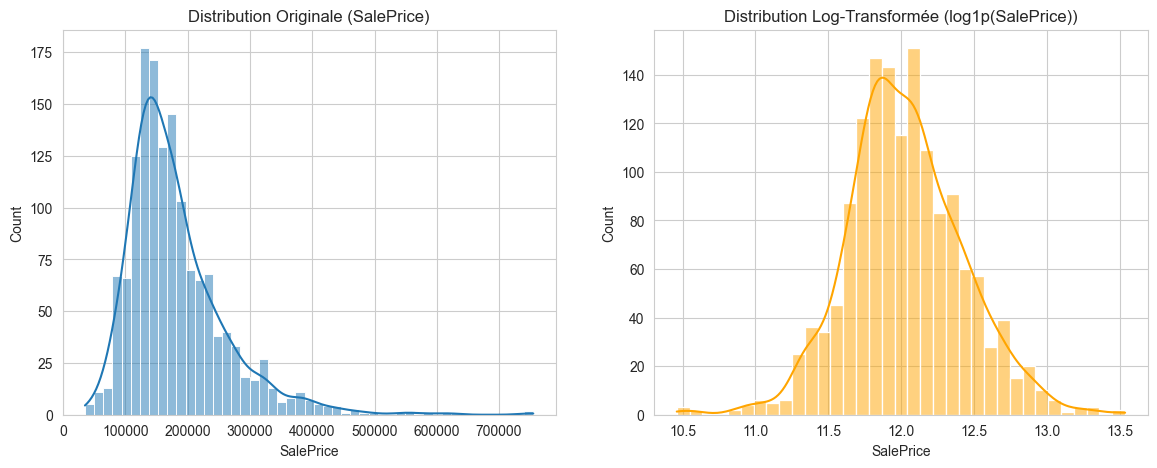

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(y, kde=True, ax=ax[0])
ax[0].set_title("Distribution Originale (SalePrice)")

sns.histplot(np.log1p(y), kde=True, ax=ax[1], color='orange')
ax[1].set_title("Distribution Log-Transformée (log1p(SalePrice))")

plt.show()

On voit clairement que la distribution log-transformée est beaucoup plus symétrique et proche d'une loi normale, ce qui aide généralement l'apprentissage.

## 2. Construction de la Pipeline

1. **Preprocessing** : Identique à la baseline (Imputation + OneHot).
2. **Modèle** : XGBoostRegressor avec des hyperparamètres initiaux robustes.
3. **TransformedTargetRegressor** : Encapsule le modèle pour gérer automatiquement le log/exp.

In [4]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

numeric_transformer = SimpleImputer(strategy="median")

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

if MODEL_TYPE == "XGBoost":
    # Hyperparamètres suggérés
    base_model = XGBRegressor(
        n_estimators=5000,
        learning_rate=0.03,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.0,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        early_stopping_rounds=None # Difficile à utiliser dans une simple Pipeline sklearn sans fit_params complexes
    )
else:
    from sklearn.ensemble import HistGradientBoostingRegressor
    base_model = HistGradientBoostingRegressor(
        max_depth=6,
        learning_rate=0.05,
        max_iter=2000,
        random_state=42
    )

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", base_model)
])

# Encapsulation pour la transformation de cible
model_final = TransformedTargetRegressor(
    regressor=pipeline,
    func=np.log1p,
    inverse_func=np.expm1
)

## 3. Évaluation CV (MAE sur échelle réelle)

Grâce à `TransformedTargetRegressor`, les prédictions en validation croisée sont automatiquement ramenées à l'échelle d'origine par `inverse_func` avant le calcul du score. Ainsi, la MAE affichée est directement comparable à celle de la baseline.

In [5]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_validate(
    model_final, X, y, cv=cv, 
    scoring="neg_mean_absolute_error", 
    return_train_score=False,
    n_jobs=-1
)

mae_scores = -scores["test_score"]

print(f"MAE par fold: {mae_scores}")
print(f"MAE moyen: {mae_scores.mean():.4f} +/- {mae_scores.std():.4f}")

MAE par fold: [15108.32226562 14641.04785156 17075.6875     15694.22753906
 12947.40039062]
MAE moyen: 15093.3371 +/- 1349.1195


## 4. Soumission

In [6]:
model_final.fit(X, y)
predictions = model_final.predict(test_df)

submission = pd.DataFrame({
    "Id": test_df["Id"],
    "SalePrice": predictions
})

submission.head()

,Id,SalePrice
0,1461,125870.070312
1,1462,157372.203125
2,1463,187047.093750
3,1464,198426.156250
4,1465,177316.828125


In [ ]:
# submission.to_csv("../submissions/submission_notebook_002.csv", index=False)